## Predicting the Length of Stay (LOS) in hospitals using the MIMIC III dataset

In [2]:
# Import the required tools
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
# Connect to sql
conn = sqlite3.connect('/Users/Merin/Desktop/HAP880/HAP_880_Project/mimic.db/mimic.db')

In [4]:
# View the tables in MIMIC database
tables = pd.read_sql('select * from sqlite_master', conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,admissions,admissions,2,"CREATE TABLE admissions(\n ""ROW_ID"" TEXT,\n ..."
1,table,callout,callout,3026,"CREATE TABLE callout(\n ""ROW_ID"" TEXT,\n ""SU..."
2,table,caregivers,caregivers,4596,"CREATE TABLE caregivers(\n ""ROW_ID"" TEXT,\n ..."
3,table,chartevents,chartevents,4652,"CREATE TABLE chartevents(\n ""ROW_ID"" TEXT,\n ..."
4,table,cptevents,cptevents,9125610,"CREATE TABLE cptevents(\n ""ROW_ID"" TEXT,\n ""..."
5,table,d_cpt,d_cpt,9139843,"CREATE TABLE d_cpt(\n ""ROW_ID"" TEXT,\n ""CATE..."
6,table,d_icd_diagnoses,d_icd_diagnoses,9139848,"CREATE TABLE d_icd_diagnoses(\n ""ROW_ID"" TEXT..."
7,table,d_icd_procedures,d_icd_procedures,9140195,"CREATE TABLE d_icd_procedures(\n ""ROW_ID"" TEX..."
8,table,d_items,d_items,9140274,"CREATE TABLE d_items(\n ""ROW_ID"" TEXT,\n ""IT..."
9,table,diagnoses_icd,diagnoses_icd,9140505,"CREATE TABLE diagnoses_icd(\n ""ROW_ID"" TEXT,\..."


In [5]:
# Tables selected for analysis

# primary admissions information
df_admin = pd.read_sql('select * from admissions', con=conn)

# information on nature of patients condition
df_cpt = pd.read_sql('select * from cptevents', con=conn)

# Intensive Care Unit (ICU) details for each admission to hospital
df_icustays = pd.read_sql('select * from icustays', con=conn)

# services used by the patient
df_services = pd.read_sql('select * from services', con=conn)

# demographic information on patients
df_patients = pd.read_sql('select * from patients', con=conn)

# information on diagonsis
df_diagnoses = pd.read_sql('select * from diagnoses_icd', con=conn)

# information on procedures
df_procedures = pd.read_sql('select * from procedures_icd', con=conn)

## Admissions table

In [6]:
df_admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null object
SUBJECT_ID              58976 non-null object
HADM_ID                 58976 non-null object
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               58976 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                58976 non-null object
RELIGION                58976 non-null object
MARITAL_STATUS          58976 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               58976 non-null object
EDOUTTIME               58976 non-null object
DIAGNOSIS               58976 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null object
HAS_CHARTEVENTS_DATA    58976 non-null object
dtypes: object(19

In [7]:
df_admin.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,,CATHOLIC,MARRIED,WHITE,,,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,,,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,,PROTESTANT QUAKER,SINGLE,WHITE,,,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [8]:
print(" Admission contains {} unique admission events".format(df_admin['HADM_ID'].nunique()))
print(" Admission contains {} unique patients".format(df_admin['SUBJECT_ID'].nunique()))

 Admission contains 58976 unique admission events
 Admission contains 46520 unique patients


### Length of Stay (Dependent variable)

In [9]:
# Converting admission time and discharge time to datetime type
df_admin['ADMITTIME'] = pd.to_datetime(df_admin['ADMITTIME'])
df_admin['DISCHTIME'] = pd.to_datetime(df_admin['DISCHTIME'])

# Calculating Length of Stay (in days)
df_admin['LOS'] = (df_admin['DISCHTIME']-df_admin['ADMITTIME']).dt.total_seconds()/86400

In [10]:
df_admin[['ADMITTIME','DISCHTIME','LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [11]:
df_admin['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [12]:
# In the case of death, we get a negative LOS value. We can see that the Hospital expire flag is 1 in case of a negative value 
# of LOS, which means that the patient dies in hospital
df_admin[df_admin['LOS']<0].head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,,UNOBTAINABLE,MARRIED,WHITE,,,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,,PROTESTANT QUAKER,,WHITE,,,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694


In [13]:
# 98 rows having deaths need to be removed
df_admin[df_admin['LOS']<0].describe()

,LOS
count,98.000000
mean,-0.290072
std,0.221997
min,-0.945139
25%,-0.412500
50%,-0.247222
75%,-0.108681
max,-0.000694


In [14]:
# Droping rows having negative LOS, since its given time of death is before admit time
df_admin = df_admin[df_admin['LOS']>0]

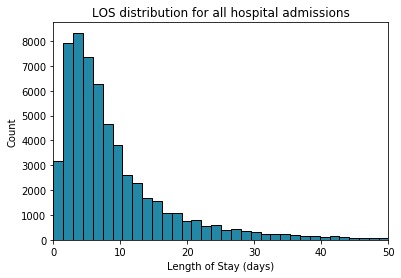

In [15]:
# Ploting a histogram of LOS
plt.hist(df_admin['LOS'],bins = 200, edgecolor='black',color ='#2388a6')
plt.xlim(0,50)
plt.title("LOS distribution for all hospital admissions")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Count")
plt.show()

### Hospital Expire Flag

In [16]:
# Also, we can see that 5774 admission events result in death
df_admin['LOS'].loc[df_admin['HOSPITAL_EXPIRE_FLAG'] == '1'].describe()

count    5774.000000
mean       10.271681
std        13.969958
min         0.001389
25%         1.965278
50%         5.917014
75%        13.071875
max       206.425694
Name: LOS, dtype: float64

### Ethinicity

In [17]:
# Ethnic groups in the dataset
df_admin['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [18]:
# Reduce ethnicity into generic categories
df_admin['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df_admin['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df_admin['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df_admin['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df_admin['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='UNKNOWN', inplace=True)
df_admin['ETHNICITY'].replace(['MULTI RACE ETHNICITY', 'PORTUGUESE','AMERICAN INDIAN/ALASKA NATIVE',
                               'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','CARIBBEAN ISLAND','SOUTH AMERICAN',
                               'MIDDLE EASTERN','AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'], 
                              value='OTHER', inplace=True)
df_admin['ETHNICITY'].value_counts()

WHITE                     41268
UNKNOWN                    5870
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
OTHER                      1830
Name: ETHNICITY, dtype: int64

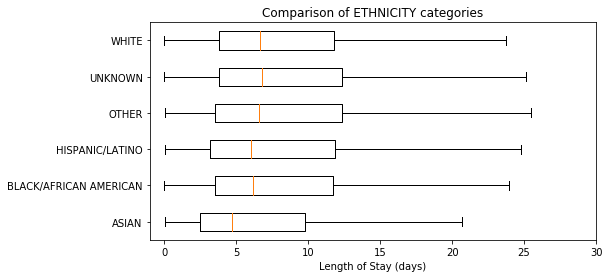

In [19]:
# Boxplot function for LOS with categories
def boxplot_los_groupby(var, los_range=(-1, 30), size=(8,4)):
    result = df_admin[[var, 'LOS']].groupby(var).median().reset_index()
    category = result[var].values.tolist()
    box_data = []
    for cat in category:
        box_data.append(df_admin['LOS'].loc[df_admin[var]==cat].values)
    fig, ax = plt.subplots(figsize=size)
    fig.canvas.draw()
    ax.boxplot(box_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(category)
    ax.set_xlabel('Length of Stay (days)') 
    ax.set_title('Comparison of {} categories'.format(var))
    plt.show();
    
boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

### Admission Type

In [20]:
# Admission type groups
df_admin['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

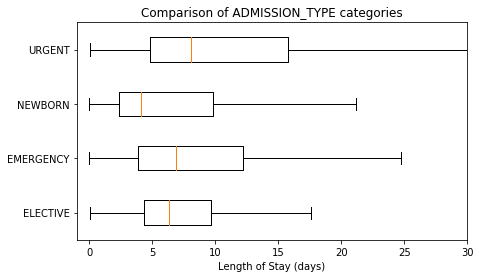

In [21]:
# We can see that Urgent have maximum median LOS
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-1, 30), size =(7,4))

### Insurance

In [22]:
# Insurance categories
df_admin['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

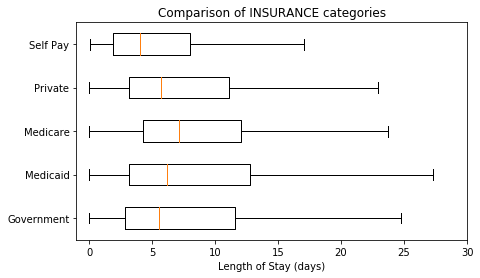

In [23]:
# We can see that Self Pay has the least median LOS
boxplot_los_groupby('INSURANCE', los_range=(-1, 30), size =(7,4))

### Marital Status

In [24]:
# Marital Status categories. NaN has 10097 counts
df_admin['MARITAL_STATUS'].value_counts()

MARRIED              24199
SINGLE               13238
                     10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [25]:
# Placing blanks under UNKNOWN (DEFAULT)
df_admin['MARITAL_STATUS'].replace([''], value='UNKNOWN (DEFAULT)', inplace=True)
df_admin['MARITAL_STATUS'].value_counts()

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

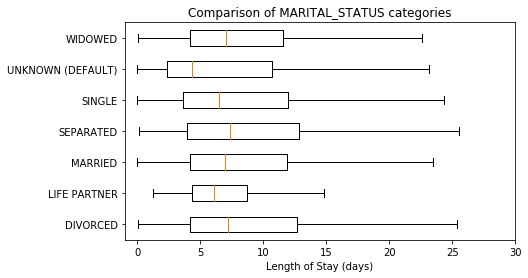

In [26]:
# Marital status with LOS
boxplot_los_groupby('MARITAL_STATUS', los_range=(-1, 30), size =(7,4))

### Admission Location

In [27]:
df_admin['ADMISSION_LOCATION'].value_counts()

EMERGENCY ROOM ADMIT         22712
PHYS REFERRAL/NORMAL DELI    15060
CLINIC REFERRAL/PREMATURE    12012
TRANSFER FROM HOSP/EXTRAM     8441
TRANSFER FROM SKILLED NUR      272
** INFO NOT AVAILABLE **       203
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: ADMISSION_LOCATION, dtype: int64

In [28]:
# Replacing ** INFO NOT AVAILABLE ** to UNKNOWN
df_admin['ADMISSION_LOCATION'].replace(['** INFO NOT AVAILABLE **'], value='UNKNOWN', inplace=True)
df_admin['ADMISSION_LOCATION'].value_counts()

EMERGENCY ROOM ADMIT         22712
PHYS REFERRAL/NORMAL DELI    15060
CLINIC REFERRAL/PREMATURE    12012
TRANSFER FROM HOSP/EXTRAM     8441
TRANSFER FROM SKILLED NUR      272
UNKNOWN                        203
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: ADMISSION_LOCATION, dtype: int64

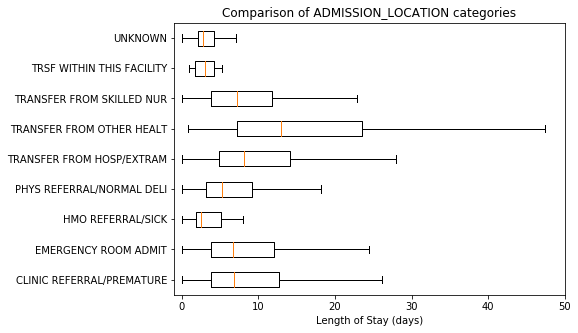

In [29]:
# Maximum median LOS is for transfer from other heath centers
boxplot_los_groupby('ADMISSION_LOCATION', los_range=(-1, 50), size =(7,5))

### Discharge Location

In [30]:
df_admin['DISCHARGE_LOCATION'].value_counts()

HOME                         18952
HOME HEALTH CARE             13962
SNF                           7705
REHAB/DISTINCT PART HOSP      6429
DEAD/EXPIRED                  5774
LONG TERM CARE HOSPITAL       2305
SHORT TERM HOSPITAL           1530
DISC-TRAN CANCER/CHLDRN H      669
DISCH-TRAN TO PSYCH HOSP       446
HOSPICE-HOME                   402
LEFT AGAINST MEDICAL ADVI      363
HOSPICE-MEDICAL FACILITY       153
HOME WITH HOME IV PROVIDR       67
OTHER FACILITY                  62
ICF                             47
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

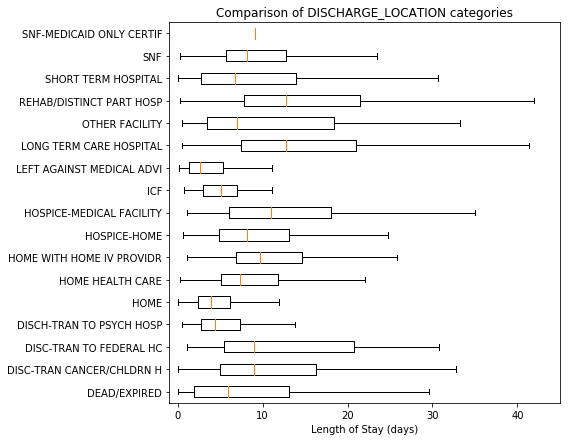

In [31]:
boxplot_los_groupby('DISCHARGE_LOCATION', los_range=(-1, 45), size =(7,7))

## Preprocessing Admissions table

In [32]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'AL', 'DL', 'INS', 'MAR','ETH']
dummy_cols = ['ADMISSION_TYPE','ADMISSION_LOCATION','DISCHARGE_LOCATION',
              'INSURANCE', 'MARITAL_STATUS','ETHNICITY']
df_admin_new = pd.get_dummies(df_admin, prefix=prefix_cols, columns=dummy_cols)

# Drop unused or no longer needed columns
# Removing HOSPITAL_EXPIRE_FLAG because DL_DEAD/EXPIRED contains the same values
df_admin_new.drop(columns=['ROW_ID','DISCHTIME','DEATHTIME','LANGUAGE','RELIGION','EDREGTIME',
                           'EDOUTTIME','DIAGNOSIS','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'], inplace=True)

df_admin_new.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,LOS,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,...,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER,ETH_UNKNOWN,ETH_WHITE
0,22,165315,2196-04-09 12:26:00,1.144444,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,23,152223,2153-09-03 07:15:00,5.496528,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,23,124321,2157-10-18 19:34:00,6.768056,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,24,161859,2139-06-06 16:14:00,2.856944,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,25,129635,2160-11-02 02:06:00,3.534028,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [33]:
df_admin_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58878 entries, 0 to 58975
Data columns (total 52 columns):
SUBJECT_ID                      58878 non-null object
HADM_ID                         58878 non-null object
ADMITTIME                       58878 non-null datetime64[ns]
LOS                             58878 non-null float64
ADM_ELECTIVE                    58878 non-null uint8
ADM_EMERGENCY                   58878 non-null uint8
ADM_NEWBORN                     58878 non-null uint8
ADM_URGENT                      58878 non-null uint8
AL_CLINIC REFERRAL/PREMATURE    58878 non-null uint8
AL_EMERGENCY ROOM ADMIT         58878 non-null uint8
AL_HMO REFERRAL/SICK            58878 non-null uint8
AL_PHYS REFERRAL/NORMAL DELI    58878 non-null uint8
AL_TRANSFER FROM HOSP/EXTRAM    58878 non-null uint8
AL_TRANSFER FROM OTHER HEALT    58878 non-null uint8
AL_TRANSFER FROM SKILLED NUR    58878 non-null uint8
AL_TRSF WITHIN THIS FACILITY    58878 non-null uint8
AL_UNKNOWN                    

## CPT events table

In [34]:
df_cpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573146 entries, 0 to 573145
Data columns (total 12 columns):
ROW_ID              573146 non-null object
SUBJECT_ID          573146 non-null object
HADM_ID             573146 non-null object
COSTCENTER          573146 non-null object
CHARTDATE           573146 non-null object
CPT_CD              573146 non-null object
CPT_NUMBER          573146 non-null object
CPT_SUFFIX          573146 non-null object
TICKET_ID_SEQ       573146 non-null object
SECTIONHEADER       573146 non-null object
SUBSECTIONHEADER    573146 non-null object
DESCRIPTION         573146 non-null object
dtypes: object(12)
memory usage: 52.5+ MB


In [35]:
df_cpt.head()

,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
0,317,11743,129545,ICU,,99232,99232,,6,Evaluation and management,Hospital inpatient services,
1,318,11743,129545,ICU,,99232,99232,,7,Evaluation and management,Hospital inpatient services,
2,319,11743,129545,ICU,,99232,99232,,8,Evaluation and management,Hospital inpatient services,
3,320,11743,129545,ICU,,99232,99232,,9,Evaluation and management,Hospital inpatient services,
4,321,6185,183725,ICU,,99223,99223,,1,Evaluation and management,Hospital inpatient services,


### Cost Center
#### COSTCENTER is the cost center which billed for the corresponding CPT codes. There are two possible cost centers: ‘ICU’ and ‘Resp’. ‘Resp’ codes correspond to mechanical or non-invasive ventilation and were billed by the respiratory therapist. ‘ICU’ codes correspond to the procedures billed for by the ICU.

In [36]:
df_cpt['COSTCENTER'].value_counts()

ICU     471601
Resp    101545
Name: COSTCENTER, dtype: int64

### CPT Sequence Number

In [37]:
cpt_list1 = []
cpt_list1 = pd.DataFrame(df_cpt.groupby(['HADM_ID'], sort=False)['CPT_CD'].count()).reset_index()
cpt_list1.head()

,HADM_ID,CPT_CD
0,129545,13
1,183725,1
2,126380,6
3,126199,3
4,129118,2


## Preprocessing CPT events table

In [38]:
cpt_list2 = []
cpt_list3 = []
cpt_list2 = df_cpt.groupby('HADM_ID')['COSTCENTER'].apply(list).reset_index()
cpt_list3 = pd.get_dummies(cpt_list2['COSTCENTER'].apply(pd.Series).stack()).max(level=0)
cpt_list3 = cpt_list3.join(cpt_list2['HADM_ID'], how="outer")
cpt_list3.head()

,ICU,Resp,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,1,100009


In [39]:
df_cpt_new = cpt_list3.merge(cpt_list1, how='inner', on='HADM_ID')
df_cpt_new.columns = ['CPT_ICU','CPT_RESP','HADM_ID','CPT_SEQUENCE_NUMBER']
df_cpt_new.head()

,CPT_ICU,CPT_RESP,HADM_ID,CPT_SEQUENCE_NUMBER
0,1,0,100001,8
1,1,0,100003,8
2,1,0,100006,10
3,1,0,100007,5
4,1,1,100009,11


In [40]:
df_cpt_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44148 entries, 0 to 44147
Data columns (total 4 columns):
CPT_ICU                44148 non-null uint8
CPT_RESP               44148 non-null uint8
HADM_ID                44148 non-null object
CPT_SEQUENCE_NUMBER    44148 non-null int64
dtypes: int64(1), object(1), uint8(2)
memory usage: 1.1+ MB


## ICU stays table

In [41]:
df_icustays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
ROW_ID            61532 non-null object
SUBJECT_ID        61532 non-null object
HADM_ID           61532 non-null object
ICUSTAY_ID        61532 non-null object
DBSOURCE          61532 non-null object
FIRST_CAREUNIT    61532 non-null object
LAST_CAREUNIT     61532 non-null object
FIRST_WARDID      61532 non-null object
LAST_WARDID       61532 non-null object
INTIME            61532 non-null object
OUTTIME           61532 non-null object
LOS               61532 non-null object
dtypes: object(12)
memory usage: 5.6+ MB


In [42]:
df_icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.06
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


### First care unit

In [43]:
df_icustays['FIRST_CAREUNIT'].value_counts()

MICU     21088
CSRU      9312
SICU      8891
NICU      8100
CCU       7726
TSICU     6415
Name: FIRST_CAREUNIT, dtype: int64

### Last care unit

In [44]:
df_icustays['LAST_CAREUNIT'].value_counts()

MICU     21310
CSRU      9392
SICU      9213
NICU      8100
CCU       7406
TSICU     6111
Name: LAST_CAREUNIT, dtype: int64

## Preprocessing ICU stays table

In [45]:
icu_list1 = []
icu_list2 = []
icu_list1 = pd.DataFrame(df_icustays.groupby('HADM_ID')['FIRST_CAREUNIT'].apply(list).reset_index())
icu_list2 = pd.get_dummies(icu_list1['FIRST_CAREUNIT'].apply(pd.Series).stack()).max(level=0)
icu_list2.head()

,CCU,CSRU,MICU,NICU,SICU,TSICU
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,1,0,0,0,0


In [46]:
icu_list3 = icu_list2.join(icu_list1['HADM_ID'], how="outer")
icu_list3.columns = ['FC_CCU','FC_CSRU','FC_MICU','FC_NICU','FC_SICU','FC_TSICU','HADM_ID']
icu_list3.head()

,FC_CCU,FC_CSRU,FC_MICU,FC_NICU,FC_SICU,FC_TSICU,HADM_ID
0,0,0,1,0,0,0,100001
1,0,0,1,0,0,0,100003
2,0,0,1,0,0,0,100006
3,0,0,0,0,1,0,100007
4,0,1,0,0,0,0,100009


In [47]:
icu_list4 = []
icu_list5 = []
icu_list4 = pd.DataFrame(df_icustays.groupby('HADM_ID')['LAST_CAREUNIT'].apply(list).reset_index())
icu_list5 = pd.get_dummies(icu_list4['LAST_CAREUNIT'].apply(pd.Series).stack()).max(level=0)
icu_list5.head()

,CCU,CSRU,MICU,NICU,SICU,TSICU
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,1,0,0,0,0


In [48]:
icu_list6 = icu_list5.join(icu_list4['HADM_ID'], how="outer")
icu_list6.columns = ['LC_CCU','LC_CSRU','LC_MICU','LC_NICU','LC_SICU','LC_TSICU','HADM_ID']
icu_list6.head()

,LC_CCU,LC_CSRU,LC_MICU,LC_NICU,LC_SICU,LC_TSICU,HADM_ID
0,0,0,1,0,0,0,100001
1,0,0,1,0,0,0,100003
2,0,0,1,0,0,0,100006
3,0,0,0,0,0,1,100007
4,0,1,0,0,0,0,100009


In [49]:
df_icustays_new = icu_list3.merge(icu_list6, how='inner', on='HADM_ID')
df_icustays_new.head()

,FC_CCU,FC_CSRU,FC_MICU,FC_NICU,FC_SICU,FC_TSICU,HADM_ID,LC_CCU,LC_CSRU,LC_MICU,LC_NICU,LC_SICU,LC_TSICU
0,0,0,1,0,0,0,100001,0,0,1,0,0,0
1,0,0,1,0,0,0,100003,0,0,1,0,0,0
2,0,0,1,0,0,0,100006,0,0,1,0,0,0
3,0,0,0,0,1,0,100007,0,0,0,0,0,1
4,0,1,0,0,0,0,100009,0,1,0,0,0,0


In [50]:
df_icustays_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57786 entries, 0 to 57785
Data columns (total 13 columns):
FC_CCU      57786 non-null uint8
FC_CSRU     57786 non-null uint8
FC_MICU     57786 non-null uint8
FC_NICU     57786 non-null uint8
FC_SICU     57786 non-null uint8
FC_TSICU    57786 non-null uint8
HADM_ID     57786 non-null object
LC_CCU      57786 non-null uint8
LC_CSRU     57786 non-null uint8
LC_MICU     57786 non-null uint8
LC_NICU     57786 non-null uint8
LC_SICU     57786 non-null uint8
LC_TSICU    57786 non-null uint8
dtypes: object(1), uint8(12)
memory usage: 1.5+ MB


## Services table

In [51]:
df_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73343 entries, 0 to 73342
Data columns (total 6 columns):
ROW_ID          73343 non-null object
SUBJECT_ID      73343 non-null object
HADM_ID         73343 non-null object
TRANSFERTIME    73343 non-null object
PREV_SERVICE    73343 non-null object
CURR_SERVICE    73343 non-null object
dtypes: object(6)
memory usage: 3.4+ MB


In [52]:
df_services.head()

,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG
2,760,472,173064,2172-09-28 19:22:15,,CMED
3,761,473,129194,2201-01-09 20:16:45,,NB
4,762,474,194246,2181-03-23 08:24:41,,NB


### Current Service

In [53]:
df_services['CURR_SERVICE'].value_counts()

MED      24866
CMED      9135
CSURG     7911
NB        7806
SURG      5514
NSURG     4100
TRAUM     3137
NMED      2957
OMED      2286
VSURG     1455
TSURG     1338
ORTHO     1101
GU         436
NBB        346
GYN        306
PSURG      283
ENT        247
OBS        113
DENT         5
PSYCH        1
Name: CURR_SERVICE, dtype: int64

## Preprocessing Services table

In [54]:
ser_list1 = []
ser_list2 = []
ser_list1 = pd.DataFrame(df_services.groupby('HADM_ID')['CURR_SERVICE'].apply(list).reset_index())
ser_list2 = pd.get_dummies(ser_list1['CURR_SERVICE'].apply(pd.Series).stack()).max(level=0)
ser_list2.head()

,CMED,CSURG,DENT,ENT,GU,GYN,MED,NB,NBB,NMED,NSURG,OBS,OMED,ORTHO,PSURG,PSYCH,SURG,TRAUM,TSURG,VSURG
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
df_services_new = ser_list2.join(ser_list1['HADM_ID'], how="outer")
df_services_new.head()

,CMED,CSURG,DENT,ENT,GU,GYN,MED,NB,NBB,NMED,...,OBS,OMED,ORTHO,PSURG,PSYCH,SURG,TRAUM,TSURG,VSURG,HADM_ID
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,100001
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,100003
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,100006
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,100007
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100009


In [56]:
df_services_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58926 entries, 0 to 58925
Data columns (total 21 columns):
CMED       58926 non-null uint8
CSURG      58926 non-null uint8
DENT       58926 non-null uint8
ENT        58926 non-null uint8
GU         58926 non-null uint8
GYN        58926 non-null uint8
MED        58926 non-null uint8
NB         58926 non-null uint8
NBB        58926 non-null uint8
NMED       58926 non-null uint8
NSURG      58926 non-null uint8
OBS        58926 non-null uint8
OMED       58926 non-null uint8
ORTHO      58926 non-null uint8
PSURG      58926 non-null uint8
PSYCH      58926 non-null uint8
SURG       58926 non-null uint8
TRAUM      58926 non-null uint8
TSURG      58926 non-null uint8
VSURG      58926 non-null uint8
HADM_ID    58926 non-null object
dtypes: object(1), uint8(20)
memory usage: 4.5+ MB


## Patients table

In [57]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
ROW_ID         46520 non-null object
SUBJECT_ID     46520 non-null object
GENDER         46520 non-null object
DOB            46520 non-null object
DOD            46520 non-null object
DOD_HOSP       46520 non-null object
DOD_SSN        46520 non-null object
EXPIRE_FLAG    46520 non-null object
dtypes: object(8)
memory usage: 2.8+ MB


In [58]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,,,,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,,1
2,236,251,M,2090-03-15 00:00:00,,,,0
3,237,252,M,2078-03-06 00:00:00,,,,0
4,238,253,F,2089-11-26 00:00:00,,,,0


### Gender

In [59]:
df_patients['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

### DOB

In [60]:
# Convert to datetime type
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'])
df_patients['DOB'].head()

0   2075-03-13
1   2164-12-27
2   2090-03-15
3   2078-03-06
4   2089-11-26
Name: DOB, dtype: datetime64[ns]

## Preprocessing Patients table

In [61]:
pat_list1 = []
pat_list2 = []
pat_list1 = pd.DataFrame(df_patients.groupby('SUBJECT_ID')['GENDER'].apply(list).reset_index())
pat_list2 = pd.get_dummies(pat_list1['GENDER'].apply(pd.Series).stack()).max(level=0)
pat_list2.head()

,F,M
0,1,0
1,1,0
2,0,1
3,0,1
4,0,1


In [62]:
pat_list3 = pat_list2.join(pat_list1['SUBJECT_ID'], how="outer")
pat_list3.head()

,F,M,SUBJECT_ID
0,1,0,10
1,1,0,100
2,0,1,1000
3,0,1,10000
4,0,1,10001


In [63]:
df_patients_new = pat_list3.join(df_patients['DOB'], how="outer")
df_patients_new.head()

,F,M,SUBJECT_ID,DOB
0,1,0,10,2075-03-13
1,1,0,100,2164-12-27
2,0,1,1000,2090-03-15
3,0,1,10000,2078-03-06
4,0,1,10001,2089-11-26


In [64]:
df_patients_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46520 entries, 0 to 46519
Data columns (total 4 columns):
F             46520 non-null uint8
M             46520 non-null uint8
SUBJECT_ID    46520 non-null object
DOB           46520 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1), uint8(2)
memory usage: 2.4+ MB


## Procedures ICD table

In [65]:
df_procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240095 entries, 0 to 240094
Data columns (total 5 columns):
ROW_ID        240095 non-null object
SUBJECT_ID    240095 non-null object
HADM_ID       240095 non-null object
SEQ_NUM       240095 non-null object
ICD9_CODE     240095 non-null object
dtypes: object(5)
memory usage: 9.2+ MB


In [66]:
df_procedures.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,0331


## Preprocessing Procedures ICD table
### Procedure Number

In [67]:
# “Procedures number” is used to reﬂect the total procedures performed on the patient during the stay at the ICU, without 
# focusing on the speciﬁc type of those procedures.

df_procedures_new = []
df_procedures_new = pd.DataFrame(df_procedures.groupby(['HADM_ID'], sort=False)['SEQ_NUM'].max()).reset_index()
df_procedures_new.columns =['HADM_ID','PRO_NUM']
df_procedures_new.head()

,HADM_ID,PRO_NUM
0,154460,3
1,130856,2
2,119355,3
3,158060,1
4,189217,3


In [68]:
df_procedures_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52243 entries, 0 to 52242
Data columns (total 2 columns):
HADM_ID    52243 non-null object
PRO_NUM    52243 non-null object
dtypes: object(2)
memory usage: 816.4+ KB


## Diagnosis ICD table

In [69]:
df_diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1,40301
1,1298,109,172335,2,486
2,1299,109,172335,3,58281
3,1300,109,172335,4,5855
4,1301,109,172335,5,4254


In [70]:
df_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null object
SUBJECT_ID    651047 non-null object
HADM_ID       651047 non-null object
SEQ_NUM       651047 non-null object
ICD9_CODE     651047 non-null object
dtypes: object(5)
memory usage: 24.8+ MB


### ICD9_CODE

In [71]:
df_diagnoses['ICD9_CODE'].value_counts()

4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
25000     9058
2724      8690
51881     7497
5990      6555
53081     6326
2720      5930
V053      5779
V290      5519
2859      5406
2449      4917
486       4839
2851      4552
2762      4528
496       4431
99592     3912
V5861     3806
0389      3725
5070      3680
V3000     3566
5859      3435
311       3431
40390     3421
3051      3358
412       3278
2875      3065
         ...  
33701        1
2702         1
33521        1
1348         1
2306         1
7741         1
9555         1
6182         1
7428         1
73002        1
31539        1
7848         1
37024        1
71944        1
00861        1
83979        1
66944        1
94325        1
80151        1
7597         1
37501        1
80423        1
29575        1
64204        1
V091         1
71198        1
65671        1
63380        1
2110         1
1920         1
Name: ICD9_CODE, Length: 6985, dtype: int64

## Preprocessing Diagnoses ICD table

In [72]:
# Truncate first three character values. Take out codes starting with V and E
df_diagnoses['code'] = df_diagnoses['ICD9_CODE']
df_diagnoses['code'] = df_diagnoses['code'][~df_diagnoses['code'].str.contains("[a-zA-Z]").fillna(False)]
df_diagnoses['code'] = df_diagnoses['code'].replace('',np.nan, regex=True)
df_diagnoses['code'].fillna(value='999', inplace=True)

In [73]:
df_diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,code
0,1297,109,172335,1,40301,40301
1,1298,109,172335,2,486,486
2,1299,109,172335,3,58281,58281
3,1300,109,172335,4,5855,5855
4,1301,109,172335,5,4254,4254


In [74]:
df_diagnoses['code'] = df_diagnoses['code'].str.slice(start=0, stop=3, step=1)

In [75]:
df_diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,code
0,1297,109,172335,1,40301,403
1,1298,109,172335,2,486,486
2,1299,109,172335,3,58281,582
3,1300,109,172335,4,5855,585
4,1301,109,172335,5,4254,425


In [76]:
df_diagnoses['code'] = df_diagnoses['code'].astype(int)

In [77]:
# ICD9_CODES Main Category ranges (Super categories of ICD codes)
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Category names
diagnoses_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood_diseases',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'symptoms',
             16: 'injury', 17: 'misc'}

# Recode in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagnoses['code'] = np.where(df_diagnoses['code'].between(cat_range[0],cat_range[1]),num,df_diagnoses['code'])
    
# Convert integer to category name using diagnoses_dict
df_diagnoses['code'] = df_diagnoses['code']
df_diagnoses['category'] = df_diagnoses['code'].replace(diagnoses_dict)

In [78]:
df_diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,code,category
0,1297,109,172335,1,40301,6,circulatory
1,1298,109,172335,2,486,7,respiratory
2,1299,109,172335,3,58281,9,genitourinary
3,1300,109,172335,4,5855,9,genitourinary
4,1301,109,172335,5,4254,6,circulatory


In [79]:
# Diagnoses for each admission
ICD_list1 = df_diagnoses.groupby('HADM_ID')['category'].apply(list).reset_index()
ICD_list1.head()

,HADM_ID,category
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood_diseases, infectious, digest..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [80]:
ICD_list2 = pd.get_dummies(ICD_list1['category'].apply(pd.Series).stack()).max(level=0)
ICD_list2.head()

,blood_diseases,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,symptoms
0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1
3,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [81]:
df_diagnoses_new = ICD_list2.join(ICD_list1['HADM_ID'], how="outer")
df_diagnoses_new.head()

,blood_diseases,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,symptoms,HADM_ID
0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,100001
1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,100003
2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,100006
3,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,100007
4,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,100009


## Merge all preprocessed tables

In [82]:
df_admin_new.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,LOS,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,...,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER,ETH_UNKNOWN,ETH_WHITE
0,22,165315,2196-04-09 12:26:00,1.144444,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,23,152223,2153-09-03 07:15:00,5.496528,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,23,124321,2157-10-18 19:34:00,6.768056,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,24,161859,2139-06-06 16:14:00,2.856944,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,25,129635,2160-11-02 02:06:00,3.534028,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [83]:
df_cpt_new.head()

,CPT_ICU,CPT_RESP,HADM_ID,CPT_SEQUENCE_NUMBER
0,1,0,100001,8
1,1,0,100003,8
2,1,0,100006,10
3,1,0,100007,5
4,1,1,100009,11


In [84]:
df_icustays_new.head()

,FC_CCU,FC_CSRU,FC_MICU,FC_NICU,FC_SICU,FC_TSICU,HADM_ID,LC_CCU,LC_CSRU,LC_MICU,LC_NICU,LC_SICU,LC_TSICU
0,0,0,1,0,0,0,100001,0,0,1,0,0,0
1,0,0,1,0,0,0,100003,0,0,1,0,0,0
2,0,0,1,0,0,0,100006,0,0,1,0,0,0
3,0,0,0,0,1,0,100007,0,0,0,0,0,1
4,0,1,0,0,0,0,100009,0,1,0,0,0,0


In [85]:
df_services_new.head()

,CMED,CSURG,DENT,ENT,GU,GYN,MED,NB,NBB,NMED,...,OBS,OMED,ORTHO,PSURG,PSYCH,SURG,TRAUM,TSURG,VSURG,HADM_ID
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,100001
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,100003
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,100006
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,100007
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100009


In [86]:
df_patients_new.head()

,F,M,SUBJECT_ID,DOB
0,1,0,10,2075-03-13
1,1,0,100,2164-12-27
2,0,1,1000,2090-03-15
3,0,1,10000,2078-03-06
4,0,1,10001,2089-11-26


In [87]:
df_procedures_new.head()

,HADM_ID,PRO_NUM
0,154460,3
1,130856,2
2,119355,3
3,158060,1
4,189217,3


In [88]:
df_diagnoses_new.head()

,blood_diseases,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,symptoms,HADM_ID
0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,100001
1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,100003
2,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,100006
3,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,100007
4,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,100009


In [89]:
df = df_admin_new.merge(df_cpt_new, how='inner', on='HADM_ID')
df = df.merge(df_icustays_new, how='inner', on='HADM_ID')
df = df.merge(df_services_new, how='inner', on='HADM_ID')
df = df.merge(df_procedures_new, how='inner', on='HADM_ID')
df = df.merge(df_diagnoses_new, how='inner', on='HADM_ID')
df = df.merge(df_patients_new, how='inner', on='SUBJECT_ID')
df.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,LOS,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,symptoms,F,M,DOB
0,23,124321,2157-10-18 19:34:00,6.768056,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,1,2142-10-08
1,24,161859,2139-06-06 16:14:00,2.856944,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2066-01-08
2,25,129635,2160-11-02 02:06:00,3.534028,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2135-10-08
3,26,197661,2126-05-06 15:16:00,6.988889,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2152-03-31
4,31,128652,2108-08-22 23:27:00,7.647917,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,1,2062-08-22
5,34,115799,2186-07-18 16:46:00,1.968056,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2095-12-28
6,34,144319,2191-02-23 05:23:00,2.622917,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,2095-12-28
7,35,166707,2122-02-10 11:15:00,10.177083,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2179-08-19
8,36,182104,2131-04-30 07:15:00,8.281250,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,2140-09-20
9,36,122659,2131-05-12 19:49:00,12.736806,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,2140-09-20


## Age

In [90]:
df_age_min = df_admin[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,10,2103-06-28 11:36:00
1,100,2157-08-10 07:15:00
2,1000,2144-01-19 20:15:00
3,10000,2186-08-10 21:57:00
4,10001,2107-03-18 15:48:00


In [91]:
df_new = df_patients.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [92]:
# https://mimic.physionet.org/tutorials/intro-to-mimic-iii/
# all ages > 89 in the MIMIC database were replaced with 300

df_new['AGE'] = (df_new['ADMIT_MIN'] - df_new['DOB']).dt.days // 365
df_new['AGE'] = np.where(df_new['AGE'] <0 ,90,df_new['AGE'])
df_new['AGE'] = np.where(df_new['AGE'] == -0, 0, df_new['AGE'])
new = df_new[['SUBJECT_ID','AGE']]
new.head()

,SUBJECT_ID,AGE
0,249,74.0
1,250,23.0
2,251,20.0
3,252,55.0
4,253,84.0


In [93]:
df = df.merge(new, how='inner', on='SUBJECT_ID')
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,LOS,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,...,nervous,pregnancy,prenatal,respiratory,skin,symptoms,F,M,DOB,AGE
0,23,124321,2157-10-18 19:34:00,6.768056,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,2142-10-08,71.0
1,24,161859,2139-06-06 16:14:00,2.856944,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,2066-01-08,39.0
2,25,129635,2160-11-02 02:06:00,3.534028,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,2135-10-08,58.0
3,26,197661,2126-05-06 15:16:00,6.988889,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,2152-03-31,72.0
4,31,128652,2108-08-22 23:27:00,7.647917,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,2062-08-22,72.0


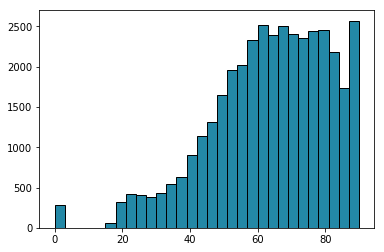

In [94]:
plt.hist(df['AGE'], bins=30, color='#2388a6', edgecolor ='black')
plt.show()

In [95]:
df['AGE'].isnull().sum()

0

## Preparing the Dependent variable

### Median LOS (days)

In [96]:
df['LOS'].median()

7.850694444444445

### Removing unwanted columns

In [97]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38385 entries, 0 to 38384
Data columns (total 109 columns):
SUBJECT_ID                      object
HADM_ID                         object
ADMITTIME                       datetime64[ns]
LOS                             float64
ADM_ELECTIVE                    uint8
ADM_EMERGENCY                   uint8
ADM_NEWBORN                     uint8
ADM_URGENT                      uint8
AL_CLINIC REFERRAL/PREMATURE    uint8
AL_EMERGENCY ROOM ADMIT         uint8
AL_HMO REFERRAL/SICK            uint8
AL_PHYS REFERRAL/NORMAL DELI    uint8
AL_TRANSFER FROM HOSP/EXTRAM    uint8
AL_TRANSFER FROM OTHER HEALT    uint8
AL_TRANSFER FROM SKILLED NUR    uint8
AL_TRSF WITHIN THIS FACILITY    uint8
AL_UNKNOWN                      uint8
DL_DEAD/EXPIRED                 uint8
DL_DISC-TRAN CANCER/CHLDRN H    uint8
DL_DISC-TRAN TO FEDERAL HC      uint8
DL_DISCH-TRAN TO PSYCH HOSP     uint8
DL_HOME                         uint8
DL_HOME HEALTH CARE             uint8
DL_

In [98]:
df_final = df.copy()

In [99]:
df_final.drop(columns=['SUBJECT_ID','HADM_ID','ADMITTIME','DOB'], inplace=True)
df_final.head()

,LOS,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,AL_HMO REFERRAL/SICK,AL_PHYS REFERRAL/NORMAL DELI,AL_TRANSFER FROM HOSP/EXTRAM,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,symptoms,F,M,AGE
0,6.768056,0,1,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,1,71.0
1,2.856944,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,39.0
2,3.534028,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,58.0
3,6.988889,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,72.0
4,7.647917,0,1,0,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,72.0


In [100]:
df_final['Class_LOS'] = np.where(df_final['LOS']<=df_final['LOS'].median(),0,1)
df_final.drop(columns=['LOS'], inplace=True)
df_final.head()

,ADM_ELECTIVE,ADM_EMERGENCY,ADM_NEWBORN,ADM_URGENT,AL_CLINIC REFERRAL/PREMATURE,AL_EMERGENCY ROOM ADMIT,AL_HMO REFERRAL/SICK,AL_PHYS REFERRAL/NORMAL DELI,AL_TRANSFER FROM HOSP/EXTRAM,AL_TRANSFER FROM OTHER HEALT,...,nervous,pregnancy,prenatal,respiratory,skin,symptoms,F,M,AGE,Class_LOS
0,0,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,71.0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,39.0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,58.0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,72.0,0
4,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,72.0,0


## Modeling with Median LOS

In [101]:
cols=list(df_final.columns)

In [102]:
cols.remove('Class_LOS')

In [103]:
sz=df_final.index.size

In [104]:
from sklearn.utils import shuffle

In [105]:
df_final=shuffle(df_final)

In [106]:
# split to training and testing
tr=df_final[:int(sz*0.8)] 
ts=df_final[int(sz*0.8):]

### Random Forest with 400 trees

In [107]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

C:\Users\Merin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


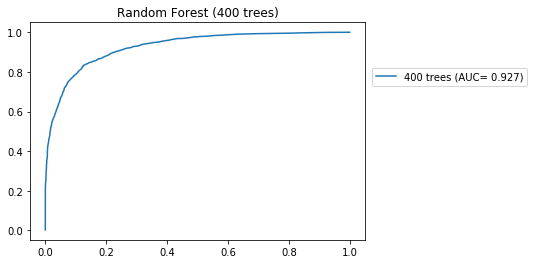

In [108]:
rf=RandomForestClassifier(n_estimators =400)
rf.fit(tr[cols],tr['Class_LOS'])
probs_rf=rf.predict_proba(ts[cols])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ts['Class_LOS'],probs_rf[:,1])
auc_rf=auc(fpr_rf,tpr_rf)
plt.title('Random Forest (400 trees)')
plt.plot(fpr_rf, tpr_rf,label = "400 trees" +" (AUC= "+str(round((auc_rf),3))+")")
plt.legend(loc='center right', bbox_to_anchor=(1,0.5,0.5,0.5))

In [109]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
y_pred = rf.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8529373453171812
Classification Report : 
              precision    recall  f1-score   support

          0       0.84      0.87      0.86      3851
          1       0.86      0.84      0.85      3826

avg / total       0.85      0.85      0.85      7677

Confusion Matrix : 
 [[3347  504]
 [ 625 3201]]


### Random Forest with n trees

In [110]:
rf = dict()
probs_rf = dict()
fpr_rf = dict()
tpr_rf = dict() 
thresholds_rf = dict()
auc_rf = dict()

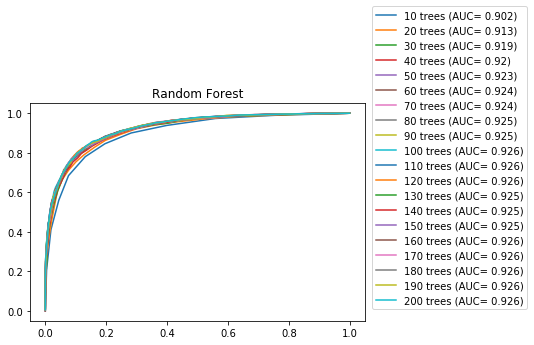

In [111]:
for i in range(10, 201, 10):
    rf[i]=RandomForestClassifier(n_estimators =i)
    rf[i].fit(tr[cols],tr['Class_LOS'])
    probs_rf[i]=rf[i].predict_proba(ts[cols])
    fpr_rf[i], tpr_rf[i], thresholds_rf[i] = roc_curve(ts['Class_LOS'],probs_rf[i][:,1])
    auc_rf[i]=auc(fpr_rf[i],tpr_rf[i])
    plt.title('Random Forest')
    plt.plot(fpr_rf[i], tpr_rf[i],label = "{} trees".format(i)+" (AUC= "+str(round((auc_rf[i]),3))+")")
    plt.legend(loc='center right', bbox_to_anchor=(1,0.5,0.5,0.5))

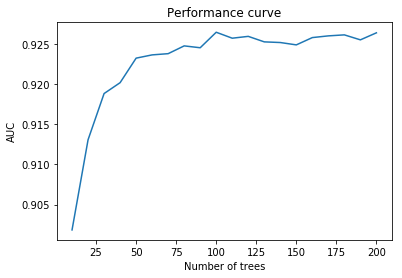

In [112]:
i_rf = []
auc_rf_plot = []
for i in range(10, 201, 10):
    i_rf.append(i)
    auc_rf_plot.append(auc_rf[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Number of trees')
plt.plot(i_rf,auc_rf_plot)

In [113]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
rf=RandomForestClassifier(n_estimators =180)
rf.fit(tr[cols],tr['Class_LOS'])
y_pred = rf.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8507229386479094
Classification Report : 
              precision    recall  f1-score   support

          0       0.84      0.87      0.85      3851
          1       0.86      0.83      0.85      3826

avg / total       0.85      0.85      0.85      7677

Confusion Matrix : 
 [[3340  511]
 [ 635 3191]]


### Feature Selection using mic and chi2

In [114]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
mic = mutual_info_classif(tr[cols],tr['Class_LOS'])
mic1=chi2(tr[cols],tr['Class_LOS'])

s=pd.DataFrame()
s['att']=cols
s['mic']=mic
s['chi']=mic1[0]
s.head()

,att,mic,chi
0,ADM_ELECTIVE,0.000085,33.173661
1,ADM_EMERGENCY,0.002139,6.828433
2,ADM_NEWBORN,0.000000,89.291667
3,ADM_URGENT,0.003974,18.042107
4,AL_CLINIC REFERRAL/PREMATURE,0.002872,29.478104


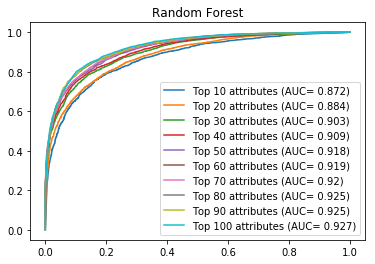

In [115]:
rf200=RandomForestClassifier(n_estimators=400)
auc_rf200_plot_mic = dict()
for i in range(10, 101, 10):
    cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:i]
    rf200.fit(tr[cols_sel_mic],tr['Class_LOS'])
    probs_rf200=rf200.predict_proba(ts[cols_sel_mic])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(ts['Class_LOS'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    auc_rf200_plot_mic[i]=auc_rf200
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_rf200),3))+")")
    plt.legend(loc='best')

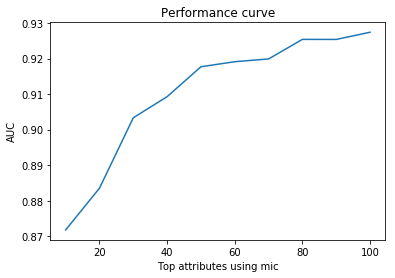

In [116]:
i_rf200 =[]
auc_rf200_plot2 = []
for i in range(10,101,10):
    i_rf200.append(i)
    auc_rf200_plot2.append(auc_rf200_plot_mic[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using mic')
plt.plot(i_rf200,auc_rf200_plot2)

In [117]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
rf=RandomForestClassifier(n_estimators =400)
cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:100]
rf.fit(tr[cols_sel_mic],tr['Class_LOS'])
y_pred = rf.predict(ts[cols_sel_mic])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8507229386479094
Classification Report : 
              precision    recall  f1-score   support

          0       0.84      0.87      0.85      3851
          1       0.86      0.83      0.85      3826

avg / total       0.85      0.85      0.85      7677

Confusion Matrix : 
 [[3346  505]
 [ 641 3185]]


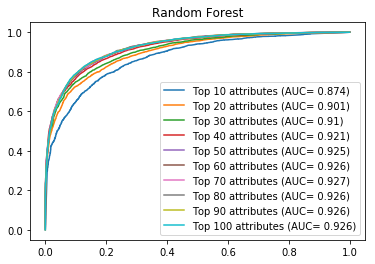

In [118]:
rf200=RandomForestClassifier(n_estimators=400)
auc_rf200_plot_chi = dict()
for i in range(10,101,10):
    cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:i]
    rf200.fit(tr[cols_sel_chi],tr['Class_LOS'])
    probs_rf200=rf200.predict_proba(ts[cols_sel_chi])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(ts['Class_LOS'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    auc_rf200_plot_chi[i]=auc_rf200
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_rf200),3))+")")
    plt.legend(loc='best')

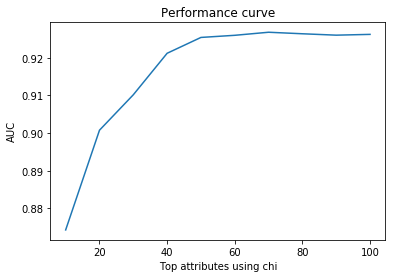

In [119]:
i_rf200 =[]
auc_rf200_plot2 = []
for i in range(10,101,10):
    i_rf200.append(i)
    auc_rf200_plot2.append(auc_rf200_plot_chi[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using chi')
plt.plot(i_rf200,auc_rf200_plot2)

In [120]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
rf=RandomForestClassifier(n_estimators =400)
cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:60]
rf.fit(tr[cols_sel_chi],tr['Class_LOS'])
y_pred = rf.predict(ts[cols_sel_chi])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8448612739351309
Classification Report : 
              precision    recall  f1-score   support

          0       0.83      0.87      0.85      3851
          1       0.86      0.82      0.84      3826

avg / total       0.85      0.84      0.84      7677

Confusion Matrix : 
 [[3332  519]
 [ 672 3154]]


### Percentage of data

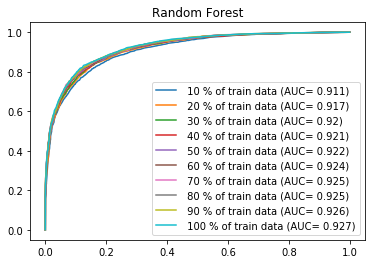

In [121]:
rf200=RandomForestClassifier(n_estimators=400)
sz=tr.index.size
auc_rf200_percent = dict()
for i in range (10, 101, 10):
    tt=tr[:int(sz*i/100.0)]
    rf200.fit(tt[cols],tt['Class_LOS'])
    probs_rf200=rf200.predict_proba(ts[cols])
    fpr_rf200, tpr_rf200, thresholds_rf200 = roc_curve(ts['Class_LOS'],probs_rf200[:,1])
    auc_rf200=auc(fpr_rf200,tpr_rf200)
    auc_rf200_percent[i] =auc_rf200
    plt.title('Random Forest')
    plt.plot(fpr_rf200, tpr_rf200, label = " {} % of train data".format(i)+" (AUC= "+str(round((auc_rf200),3))+")")
    plt.legend(loc='best')

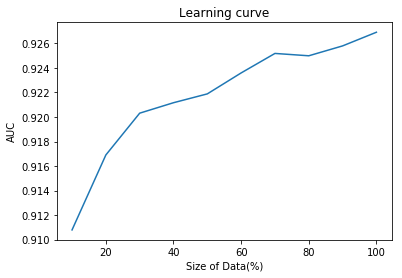

In [122]:
i_rf200 =[]
auc_rf200_plot_per = []
for i in range(10, 101, 10):
    i_rf200.append(i)
    auc_rf200_plot_per.append(auc_rf200_percent[i])
plt.title('Learning curve')
plt.ylabel('AUC')
plt.xlabel('Size of Data(%)')
plt.plot(i_rf200,auc_rf200_plot_per)

In [123]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
rf=RandomForestClassifier(n_estimators =400)
tt=tr[:int(sz*90/100.0)]
rf.fit(tt[cols],tt['Class_LOS'])
y_pred = rf.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8475967174677609
Classification Report : 
              precision    recall  f1-score   support

          0       0.84      0.87      0.85      3851
          1       0.86      0.83      0.84      3826

avg / total       0.85      0.85      0.85      7677

Confusion Matrix : 
 [[3335  516]
 [ 654 3172]]


### Logistic Regression 

In [124]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

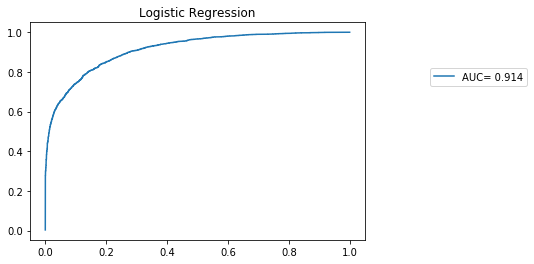

In [126]:
lr=LogisticRegression()
lr.fit(tr[cols],tr['Class_LOS'])
probs_lr=lr.predict_proba(ts[cols])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['Class_LOS'],probs_lr[:,1])
auc_lr=auc(fpr_lr,tpr_lr)
plt.title('Logistic Regression')
plt.plot(fpr_lr, tpr_lr,label = "AUC= "+str(round((auc_lr),3)))
plt.legend(loc='center right', bbox_to_anchor=(1,0.5,0.5,0.5))

In [127]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
y_pred = lr.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8283183535235118
Classification Report : 
              precision    recall  f1-score   support

          0       0.81      0.86      0.83      3851
          1       0.85      0.79      0.82      3826

avg / total       0.83      0.83      0.83      7677

Confusion Matrix : 
 [[3330  521]
 [ 797 3029]]


### Feature Selection using mic and chi2

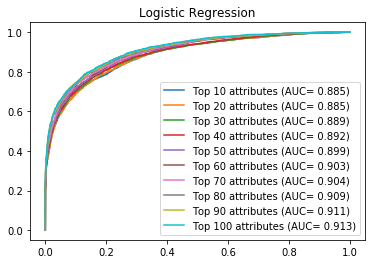

In [128]:
lr=LogisticRegression()
auc_lr_plot_mic = dict()
for i in range(10,101,10):
    cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:i]
    lr.fit(tr[cols_sel_mic],tr['Class_LOS'])
    probs_lr=lr.predict_proba(ts[cols_sel_mic])
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['Class_LOS'],probs_lr[:,1])
    auc_lr=auc(fpr_lr,tpr_lr)
    auc_lr_plot_mic[i]=auc_lr
    plt.title('Logistic Regression')
    plt.plot(fpr_lr, tpr_lr,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_lr),3))+")")
    plt.legend(loc='best')

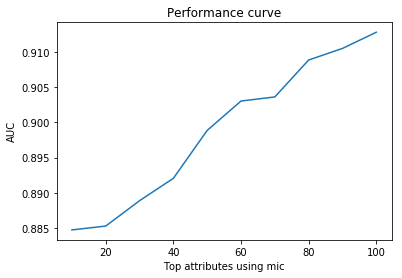

In [129]:
i_lr =[]
auc_lr_plot2 = []
for i in range(10,101,10):
    i_lr.append(i)
    auc_lr_plot2.append(auc_lr_plot_mic[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using mic')
plt.plot(i_lr,auc_lr_plot2)

In [130]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:100]
lr.fit(tr[cols_sel_mic],tr['Class_LOS'])
y_pred = lr.predict(ts[cols_sel_mic])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8294906864660675
Classification Report : 
              precision    recall  f1-score   support

          0       0.81      0.86      0.84      3851
          1       0.85      0.79      0.82      3826

avg / total       0.83      0.83      0.83      7677

Confusion Matrix : 
 [[3329  522]
 [ 787 3039]]


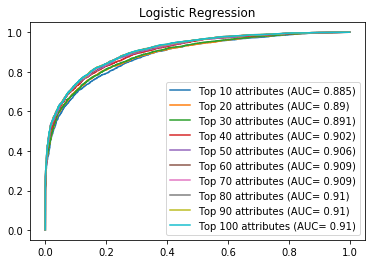

In [131]:
lr=LogisticRegression()
auc_lr_plot_chi = dict()
for i in range(10,101,10):
    cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:i]
    lr.fit(tr[cols_sel_chi],tr['Class_LOS'])
    probs_lr=lr.predict_proba(ts[cols_sel_chi])
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['Class_LOS'],probs_lr[:,1])
    auc_lr=auc(fpr_lr,tpr_lr)
    auc_lr_plot_chi[i]=auc_lr
    plt.title('Logistic Regression')
    plt.plot(fpr_lr, tpr_lr,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_lr),3))+")")
    plt.legend(loc='best')

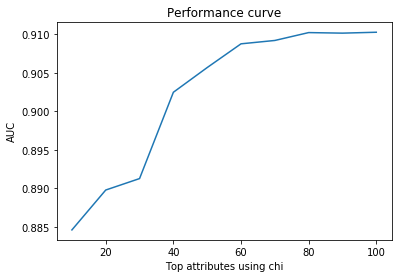

In [132]:
i_lr =[]
auc_lr_plot2 = []
for i in range(10,101,10):
    i_lr.append(i)
    auc_lr_plot2.append(auc_lr_plot_chi[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using chi')
plt.plot(i_lr,auc_lr_plot2)

In [133]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:70]
lr.fit(tr[cols_sel_chi],tr['Class_LOS'])
y_pred = lr.predict(ts[cols_sel_chi])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.8218053927315357
Classification Report : 
              precision    recall  f1-score   support

          0       0.80      0.86      0.83      3851
          1       0.85      0.79      0.81      3826

avg / total       0.82      0.82      0.82      7677

Confusion Matrix : 
 [[3304  547]
 [ 821 3005]]


### Percentage of data

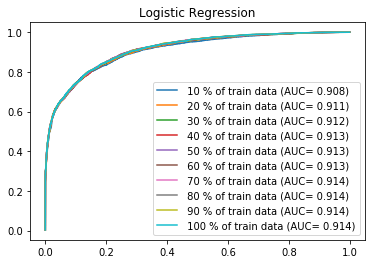

In [134]:
lr = LogisticRegression()
sz=tr.index.size
auc_lr_percent = dict()
for i in range (10, 101, 10):
    tt=tr[:int(sz*i/100.0)]
    lr.fit(tt[cols],tt['Class_LOS'])
    probs_lr=lr.predict_proba(ts[cols])
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(ts['Class_LOS'],probs_lr[:,1])
    auc_lr=auc(fpr_lr,tpr_lr)
    auc_lr_percent[i] =auc_lr
    plt.title('Logistic Regression')
    plt.plot(fpr_lr, tpr_lr, label = " {} % of train data".format(i)+" (AUC= "+str(round((auc_lr),3))+")")
    plt.legend(loc='best')

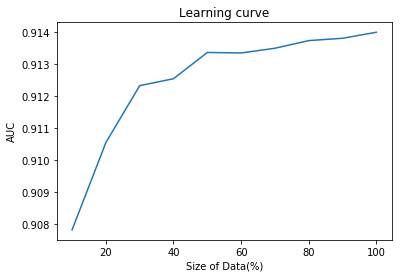

In [135]:
i_lr =[]
auc_lr_plot_per = []
for i in range(10, 101, 10):
    i_lr.append(i)
    auc_lr_plot_per.append(auc_lr_percent[i])
plt.title('Learning curve')
plt.ylabel('AUC')
plt.xlabel('Size of Data(%)')
plt.plot(i_lr,auc_lr_plot_per)

In [136]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
lr = LogisticRegression()
tt=tr[:int(sz*80/100.0)]
lr.fit(tt[cols],tt['Class_LOS'])
y_pred = lr.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.829881464113586
Classification Report : 
              precision    recall  f1-score   support

          0       0.81      0.86      0.84      3851
          1       0.85      0.80      0.82      3826

avg / total       0.83      0.83      0.83      7677

Confusion Matrix : 
 [[3329  522]
 [ 784 3042]]


### Naive Bayes

In [137]:
from sklearn.naive_bayes import GaussianNB

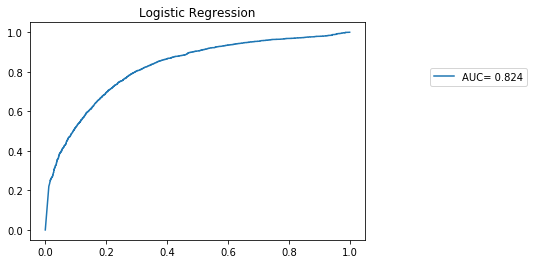

In [138]:
nb=GaussianNB()
nb.fit(tr[cols],tr['Class_LOS'])
probs_nb =nb.predict_proba(ts[cols])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(ts['Class_LOS'],probs_nb[:,1])
auc_nb =auc(fpr_nb,tpr_nb)
plt.title('Logistic Regression')
plt.plot(fpr_nb, tpr_nb,label = "AUC= "+str(round((auc_nb),3)))
plt.legend(loc='center right', bbox_to_anchor=(1,0.5,0.5,0.5))

In [139]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
y_pred = nb.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.6864660674742739
Classification Report : 
              precision    recall  f1-score   support

          0       0.85      0.45      0.59      3851
          1       0.63      0.92      0.75      3826

avg / total       0.74      0.69      0.67      7677

Confusion Matrix : 
 [[1745 2106]
 [ 301 3525]]


### Feature Selection using mic and chi2

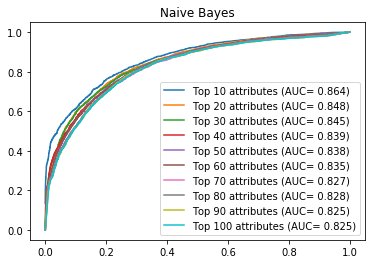

In [140]:
nb=GaussianNB()
auc_nb_plot_mic = dict()
for i in range(10,101,10):
    cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:i]
    nb.fit(tr[cols_sel_mic],tr['Class_LOS'])
    probs_nb=nb.predict_proba(ts[cols_sel_mic])
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(ts['Class_LOS'],probs_nb[:,1])
    auc_nb=auc(fpr_nb,tpr_nb)
    auc_nb_plot_mic[i]=auc_nb
    plt.title('Naive Bayes')
    plt.plot(fpr_nb, tpr_nb,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_nb),3))+")")
    plt.legend(loc='best')

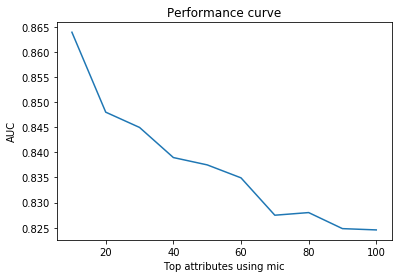

In [141]:
i_nb =[]
auc_nb_plot2 = []
for i in range(10,101,10):
    i_nb.append(i)
    auc_nb_plot2.append(auc_nb_plot_mic[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using mic')
plt.plot(i_nb,auc_nb_plot2)

In [142]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
cols_sel_mic = s.sort_values('mic', ascending=False)['att'][:10]
nb.fit(tr[cols_sel_mic],tr['Class_LOS'])
y_pred = nb.predict(ts[cols_sel_mic])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.7706135209066042
Classification Report : 
              precision    recall  f1-score   support

          0       0.73      0.85      0.79      3851
          1       0.82      0.69      0.75      3826

avg / total       0.78      0.77      0.77      7677

Confusion Matrix : 
 [[3270  581]
 [1180 2646]]


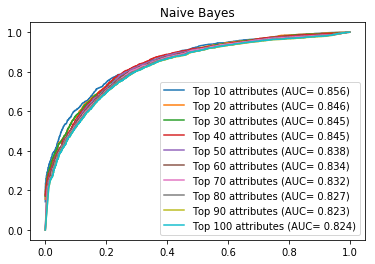

In [143]:
nb=GaussianNB()
auc_nb_plot_chi = dict()
for i in range(10,101,10):
    cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:i]
    nb.fit(tr[cols_sel_chi],tr['Class_LOS'])
    probs_nb=nb.predict_proba(ts[cols_sel_chi])
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(ts['Class_LOS'],probs_nb[:,1])
    auc_nb=auc(fpr_nb,tpr_nb)
    auc_nb_plot_chi[i]=auc_nb
    plt.title('Naive Bayes')
    plt.plot(fpr_nb, tpr_nb,label ="Top"+" {} attributes".format(i)+" (AUC= "+str(round((auc_nb),3))+")")
    plt.legend(loc='best')

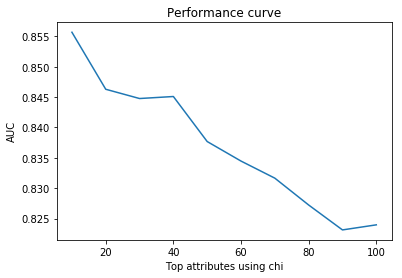

In [144]:
i_nb =[]
auc_nb_plot2 = []
for i in range(10,101,10):
    i_nb.append(i)
    auc_nb_plot2.append(auc_nb_plot_chi[i])
plt.title('Performance curve')
plt.ylabel('AUC')
plt.xlabel('Top attributes using chi')
plt.plot(i_nb,auc_nb_plot2)

In [145]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
cols_sel_chi = s.sort_values('chi', ascending=False)['att'][:10]
nb.fit(tr[cols_sel_chi],tr['Class_LOS'])
y_pred = nb.predict(ts[cols_sel_chi])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.763319004819591
Classification Report : 
              precision    recall  f1-score   support

          0       0.73      0.85      0.78      3851
          1       0.82      0.68      0.74      3826

avg / total       0.77      0.76      0.76      7677

Confusion Matrix : 
 [[3270  581]
 [1236 2590]]


### Percentage of data

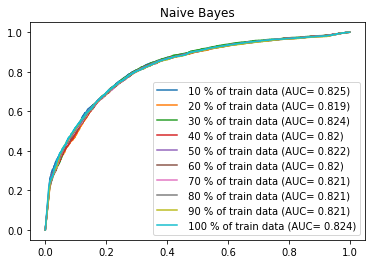

In [148]:
nb=GaussianNB()
sz=tr.index.size
auc_nb_percent = dict()
for i in range (10, 101, 10):
    tt=tr[:int(sz*i/100.0)]
    nb.fit(tt[cols],tt['Class_LOS'])
    probs_nb = nb.predict_proba(ts[cols])
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(ts['Class_LOS'],probs_nb[:,1])
    auc_nb =auc(fpr_nb,tpr_nb)
    auc_nb_percent[i] = auc_nb
    plt.title('Naive Bayes')
    plt.plot(fpr_nb, tpr_nb, label = " {} % of train data".format(i)+" (AUC= "+str(round((auc_nb),3))+")")
    plt.legend(loc='best')

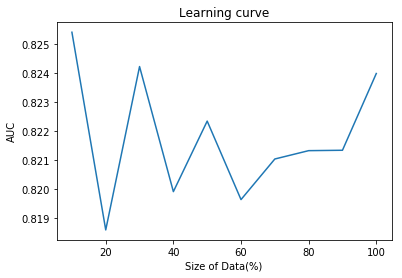

In [149]:
i_nb =[]
auc_nb_plot_per = []
for i in range(10, 101, 10):
    i_nb.append(i)
    auc_nb_plot_per.append(auc_nb_percent[i])
plt.title('Learning curve')
plt.ylabel('AUC')
plt.xlabel('Size of Data(%)')
plt.plot(i_nb,auc_nb_plot_per)

In [150]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
nb = GaussianNB()
tt=tr[:int(sz*100/100.0)]
nb.fit(tt[cols],tt['Class_LOS'])
y_pred = nb.predict(ts[cols])
print("Accuracy score : {}".format(accuracy_score(ts['Class_LOS'], y_pred)))
print("Classification Report : \n {}".format(classification_report(ts['Class_LOS'], y_pred)))
print("Confusion Matrix : \n {}".format(confusion_matrix(ts['Class_LOS'], y_pred)))

Accuracy score : 0.6864660674742739
Classification Report : 
              precision    recall  f1-score   support

          0       0.85      0.45      0.59      3851
          1       0.63      0.92      0.75      3826

avg / total       0.74      0.69      0.67      7677

Confusion Matrix : 
 [[1745 2106]
 [ 301 3525]]


In [151]:
df['LOS'].median()

7.850694444444445

## Grid Search Cross Validation

### Random Forest - Default parameters

In [385]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

rf=RandomForestClassifier()
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Random Search with Cross Validation

In [386]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters

# Creating the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, cross validation,search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, cv = 3)

# Fit the random search model
rf_random.fit(tr[cols], tr['Class_LOS'])

In [ ]:
rf_random.best_params_